### Investigation of Top Mass Observables Reweighting

This notebook investigates DCTR reweighting performance on top mass daset

* We use only the hadronic jets as input data 
* We use PFN for DCTR models
* The model is tested on reweighting from observables

The notebook investigates if there is any inconsistencies in the subsequent DCTR runs.

### Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.

In [3]:
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

from keras.callbacks import LambdaCallback, EarlyStopping

### Load the truth data for top mass 172.5 and split 80% for training and 20% for testing

Instead of using hadronic mass we used 3 particle from the hadronic top. 
* Hadronic top: 'hadronicbjet' 'wjet1' 'wjet2'
* Normalization is done as follow
    * eta,phi are centered
    * pT and mW are unit normalized

In [4]:
def normalize(x):
    mask = x[:,0] > 0 # Only process particles with postitive PT
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()
    x[mask,3] /= x[:,3].sum()

In [5]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    return X

In [6]:
data_dir = 'DCTRFitting/'

The indices for the jets are as follow
* 0: part_event['leptonbjet']   + [mtop],
* 1: part_event['hadronicbjet'] + [mtop],
* 2: part_event['lepton']       + [mtop],
* 3: part_event['neutrino']     + [mtop],
* 4 : part_event['wjet1']        + [mtop],
* 5: part_event['wjet2']        + [mtop],

Since we are focusing on hadronic top, we use the indices 1,4,5

In [7]:
default_had_mass_all = preprocess_data(np.load(data_dir + 'part_172_5_6j.npy')[:,[1,4,5],:-1])
default_had_mass = default_had_mass_all[:int(len(default_had_mass_all)*0.8)]
test_had_mass = default_had_mass_all[int(len(default_had_mass_all)*0.8):]

In [8]:
truth_had_mass = preprocess_data(np.load(data_dir + 'part_175_0_6j.npy')[:,[1,4,5],:-1])[:len(default_had_mass)]

### Prepare sample for DCTR reweighting

In [9]:
X0 = default_had_mass
Y0 = to_categorical(np.zeros(len(X0)), num_classes=2)
X0_test = preprocess_data(test_had_mass)

In [10]:
X1 = truth_had_mass
Y1 = to_categorical(np.ones(len(X1)), num_classes=2)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

In [11]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# network architecture parameters
Phi_sizes = (100,100, 128)
F_sizes = (100,100, 100)

### Define a PFN for reweighting

In [12]:
def reweighting():
    dctr_model = PFN(input_dim=4, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=False)
    save_label = 'DCTR_pfn_jets'

    checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/' + save_label + '.h5', 
                                                    monitor='val_loss', 
                                                    verbose=2, 
                                                    save_best_only=True, 
                                                    mode='min')

    CSVLogger = keras.callbacks.CSVLogger('./logs/' + save_label + '_loss.csv', append=False)

    EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  min_delta=0, 
                                                  patience=10, 
                                                  verbose=1, 
                                                  restore_best_weights=True)

    callbacks = [checkpoint, CSVLogger, EarlyStopping]
    
    history = dctr_model.fit(X_train, Y_train,
                    epochs = 100,
                    batch_size = 10,
                    validation_data = (X_test, Y_test),
                    verbose = 1, 
                    callbacks = callbacks)
    
    plt.title("Training and validation loss per epoch")
    plt.xlabel("epoch")
    plt.ylabel("loss value")
    plt.plot(dctr_model.history.history['val_loss'], label = "validation loss")
    plt.plot(dctr_model.history.history['loss'], label = "training loss loss")
    plt.legend()
    plt.show()
    
    preds = dctr_model.predict(X0_test)
    weights = preds[:,1]/preds[:,0]
    
    bins = np.linspace(0.9,1.1,50)
    plt.hist(weights, bins = bins, alpha = 0.5)[0]
    plt.title("Distribution of weight from mass 172.5 data")
    plt.show()
    
    

Train on 73868 samples, validate on 18468 samples
Epoch 1/100
73868/73868 [==============================] - 53s 718us/step - loss: 0.6967 - acc: 0.5012 - val_loss: 0.6931 - val_acc: 0.5001

Epoch 00001: val_loss improved from inf to 0.69315, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 2/100
73868/73868 [==============================] - 51s 691us/step - loss: 0.6934 - acc: 0.4978 - val_loss: 0.6931 - val_acc: 0.5001

Epoch 00002: val_loss did not improve from 0.69315
Epoch 3/100
73868/73868 [==============================] - 51s 689us/step - loss: 0.6933 - acc: 0.4997 - val_loss: 0.6934 - val_acc: 0.5001

Epoch 00003: val_loss did not improve from 0.69315
Epoch 4/100
73868/73868 [==============================] - 51s 693us/step - loss: 0.6933 - acc: 0.5012 - val_loss: 0.6933 - val_acc: 0.4999

Epoch 00004: val_loss did not improve from 0.69315
Epoch 5/100
73868/73868 [==============================] - 51s 696us/step - loss: 0.6932 - acc: 0.5017 - val_loss: 0.6932 - val_acc: 

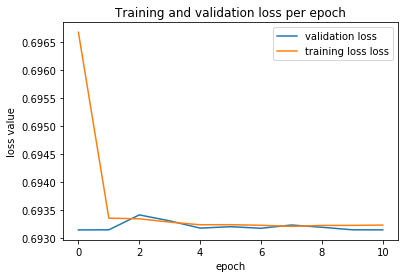

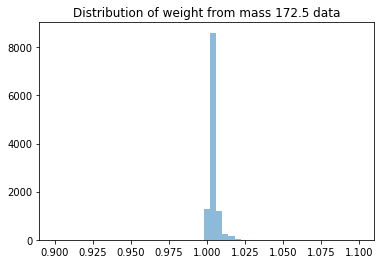

Train on 73868 samples, validate on 18468 samples
Epoch 1/100
73868/73868 [==============================] - 52s 710us/step - loss: 0.6986 - acc: 0.4963 - val_loss: 0.6931 - val_acc: 0.5001

Epoch 00001: val_loss improved from inf to 0.69314, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 2/100
73868/73868 [==============================] - 52s 705us/step - loss: 0.6934 - acc: 0.5028 - val_loss: 0.6932 - val_acc: 0.4987

Epoch 00002: val_loss did not improve from 0.69314
Epoch 3/100
73868/73868 [==============================] - 52s 703us/step - loss: 0.6933 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.5001

Epoch 00003: val_loss did not improve from 0.69314
Epoch 4/100
73868/73868 [==============================] - 52s 700us/step - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6933 - val_acc: 0.5001

Epoch 00004: val_loss did not improve from 0.69314
Epoch 5/100
73868/73868 [==============================] - 52s 702us/step - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 

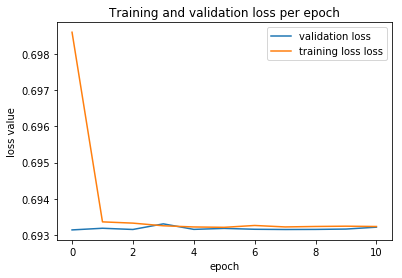

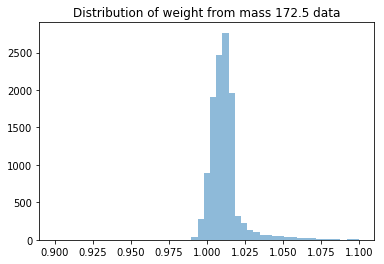

Train on 73868 samples, validate on 18468 samples
Epoch 1/100
73868/73868 [==============================] - 53s 720us/step - loss: 0.6994 - acc: 0.4982 - val_loss: 0.6934 - val_acc: 0.5015

Epoch 00001: val_loss improved from inf to 0.69335, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 2/100
73868/73868 [==============================] - 52s 705us/step - loss: 0.6934 - acc: 0.5011 - val_loss: 0.6934 - val_acc: 0.4999

Epoch 00002: val_loss did not improve from 0.69335
Epoch 3/100
73868/73868 [==============================] - 52s 707us/step - loss: 0.6932 - acc: 0.5035 - val_loss: 0.6932 - val_acc: 0.5001

Epoch 00003: val_loss improved from 0.69335 to 0.69319, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 4/100
73868/73868 [==============================] - 52s 703us/step - loss: 0.6933 - acc: 0.4964 - val_loss: 0.6932 - val_acc: 0.4999

Epoch 00004: val_loss improved from 0.69319 to 0.69319, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 5/100
73868/73868 [==

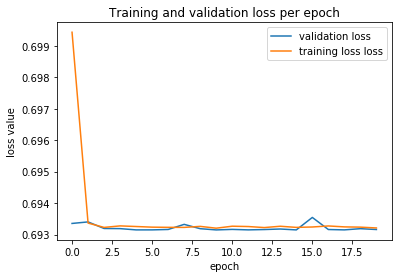

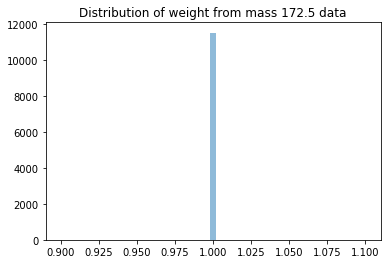

Train on 73868 samples, validate on 18468 samples
Epoch 1/100
73868/73868 [==============================] - 50s 683us/step - loss: 0.6972 - acc: 0.4982 - val_loss: 0.6931 - val_acc: 0.5028

Epoch 00001: val_loss improved from inf to 0.69311, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 2/100
73868/73868 [==============================] - 50s 681us/step - loss: 0.6933 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.4999

Epoch 00002: val_loss did not improve from 0.69311
Epoch 3/100
73868/73868 [==============================] - 50s 682us/step - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6932 - val_acc: 0.4999

Epoch 00003: val_loss did not improve from 0.69311
Epoch 4/100
73868/73868 [==============================] - 50s 683us/step - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6933 - val_acc: 0.4999

Epoch 00004: val_loss did not improve from 0.69311
Epoch 5/100
73868/73868 [==============================] - 50s 675us/step - loss: 0.6933 - acc: 0.4989 - val_loss: 0.6932 - val_acc: 

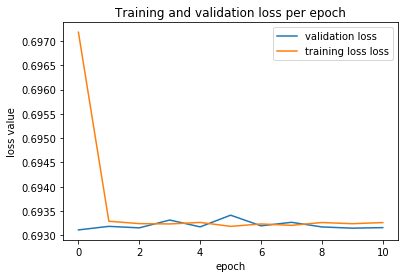

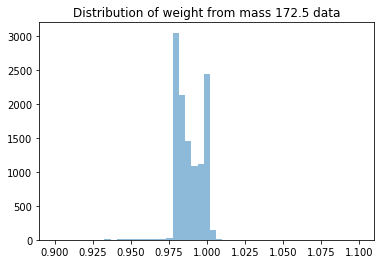

Train on 73868 samples, validate on 18468 samples
Epoch 1/100
73868/73868 [==============================] - 52s 700us/step - loss: 0.6970 - acc: 0.4988 - val_loss: 0.6932 - val_acc: 0.4990

Epoch 00001: val_loss improved from inf to 0.69315, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 2/100
73868/73868 [==============================] - 51s 691us/step - loss: 0.6934 - acc: 0.4998 - val_loss: 0.6934 - val_acc: 0.5001

Epoch 00002: val_loss did not improve from 0.69315
Epoch 3/100
73868/73868 [==============================] - 50s 676us/step - loss: 0.6933 - acc: 0.4983 - val_loss: 0.6933 - val_acc: 0.5001

Epoch 00003: val_loss did not improve from 0.69315
Epoch 4/100
73868/73868 [==============================] - 53s 714us/step - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6932 - val_acc: 0.5001

Epoch 00004: val_loss did not improve from 0.69315
Epoch 5/100
73868/73868 [==============================] - 53s 722us/step - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 

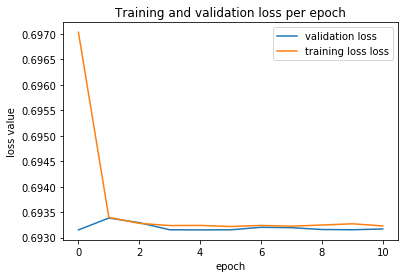

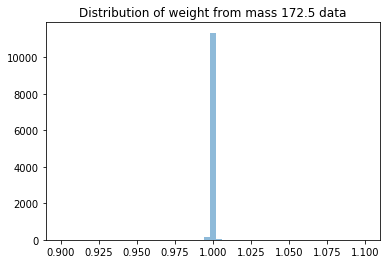

Train on 73868 samples, validate on 18468 samples
Epoch 1/100
73868/73868 [==============================] - 55s 739us/step - loss: 0.6987 - acc: 0.4979 - val_loss: 0.6933 - val_acc: 0.4991

Epoch 00001: val_loss improved from inf to 0.69327, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 2/100
73868/73868 [==============================] - 53s 724us/step - loss: 0.6934 - acc: 0.4988 - val_loss: 0.6932 - val_acc: 0.4999

Epoch 00002: val_loss improved from 0.69327 to 0.69315, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 3/100
73868/73868 [==============================] - 54s 730us/step - loss: 0.6933 - acc: 0.4982 - val_loss: 0.6933 - val_acc: 0.5001

Epoch 00003: val_loss did not improve from 0.69315
Epoch 4/100
73868/73868 [==============================] - 53s 724us/step - loss: 0.6932 - acc: 0.4994 - val_loss: 0.6932 - val_acc: 0.4999

Epoch 00004: val_loss improved from 0.69315 to 0.69315, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 5/100
73868/73868 [==

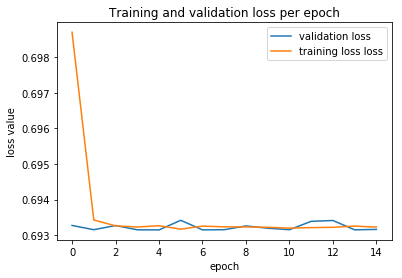

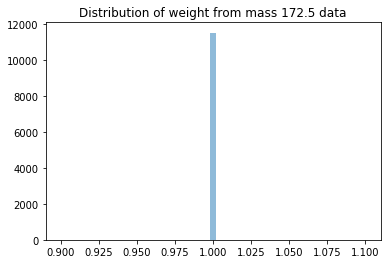

Train on 73868 samples, validate on 18468 samples
Epoch 1/100
73868/73868 [==============================] - 55s 747us/step - loss: 0.6975 - acc: 0.5001 - val_loss: 0.6933 - val_acc: 0.5014

Epoch 00001: val_loss improved from inf to 0.69329, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 2/100
73868/73868 [==============================] - 54s 730us/step - loss: 0.6933 - acc: 0.5012 - val_loss: 0.6931 - val_acc: 0.5001

Epoch 00002: val_loss improved from 0.69329 to 0.69315, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 3/100
73868/73868 [==============================] - 55s 750us/step - loss: 0.6934 - acc: 0.5006 - val_loss: 0.6943 - val_acc: 0.4999

Epoch 00003: val_loss did not improve from 0.69315
Epoch 4/100
73868/73868 [==============================] - 56s 755us/step - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6932 - val_acc: 0.5001

Epoch 00004: val_loss did not improve from 0.69315
Epoch 5/100
73868/73868 [==============================] - 56s 758us/step - loss

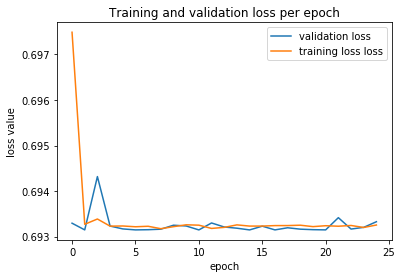

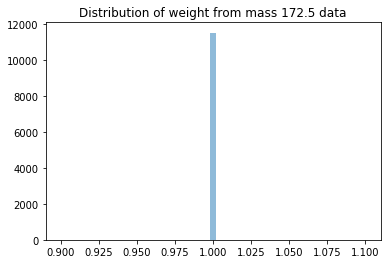

Train on 73868 samples, validate on 18468 samples
Epoch 1/100
73868/73868 [==============================] - 57s 775us/step - loss: 0.6967 - acc: 0.5037 - val_loss: 0.6932 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.69324, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 2/100
73868/73868 [==============================] - 56s 765us/step - loss: 0.6933 - acc: 0.5027 - val_loss: 0.6932 - val_acc: 0.4999

Epoch 00002: val_loss improved from 0.69324 to 0.69316, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 3/100
73868/73868 [==============================] - 56s 764us/step - loss: 0.6933 - acc: 0.4974 - val_loss: 0.6931 - val_acc: 0.5001

Epoch 00003: val_loss improved from 0.69316 to 0.69315, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 4/100
73868/73868 [==============================] - 57s 765us/step - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6933 - val_acc: 0.4999

Epoch 00004: val_loss did not improve from 0.69315
Epoch 5/100
73868/73868 [==

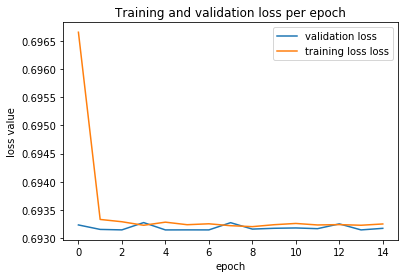

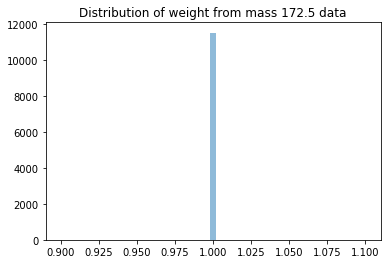

Train on 73868 samples, validate on 18468 samples
Epoch 1/100
73868/73868 [==============================] - 57s 775us/step - loss: 0.6973 - acc: 0.4998 - val_loss: 0.6933 - val_acc: 0.4999

Epoch 00001: val_loss improved from inf to 0.69327, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 2/100
73868/73868 [==============================] - 57s 768us/step - loss: 0.6933 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.4999

Epoch 00002: val_loss improved from 0.69327 to 0.69324, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 3/100
73868/73868 [==============================] - 57s 767us/step - loss: 0.6932 - acc: 0.5018 - val_loss: 0.6932 - val_acc: 0.5001

Epoch 00003: val_loss improved from 0.69324 to 0.69315, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 4/100
73868/73868 [==============================] - 57s 770us/step - loss: 0.6933 - acc: 0.5004 - val_loss: 0.6934 - val_acc: 0.5001

Epoch 00004: val_loss did not improve from 0.69315
Epoch 5/100
73868/73868 [==

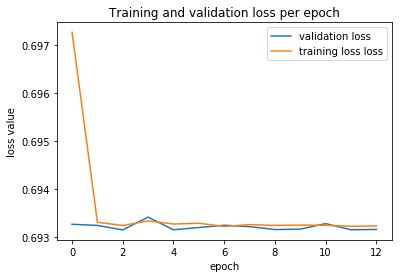

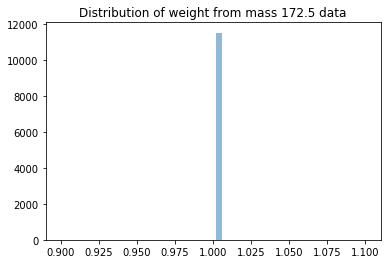

Train on 73868 samples, validate on 18468 samples
Epoch 1/100
73868/73868 [==============================] - 58s 791us/step - loss: 0.6971 - acc: 0.5014 - val_loss: 0.6932 - val_acc: 0.4999

Epoch 00001: val_loss improved from inf to 0.69317, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 2/100
73868/73868 [==============================] - 57s 773us/step - loss: 0.6935 - acc: 0.5003 - val_loss: 0.6932 - val_acc: 0.5001

Epoch 00002: val_loss improved from 0.69317 to 0.69316, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 3/100
73868/73868 [==============================] - 57s 773us/step - loss: 0.6932 - acc: 0.4982 - val_loss: 0.6934 - val_acc: 0.5001

Epoch 00003: val_loss did not improve from 0.69316
Epoch 4/100
73868/73868 [==============================] - 58s 779us/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.4999

Epoch 00004: val_loss did not improve from 0.69316
Epoch 5/100
73868/73868 [==============================] - 57s 773us/step - loss

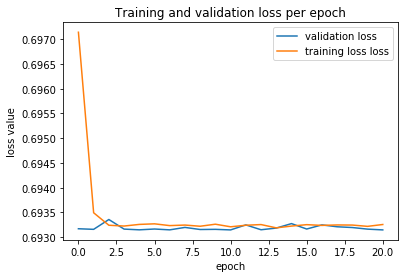

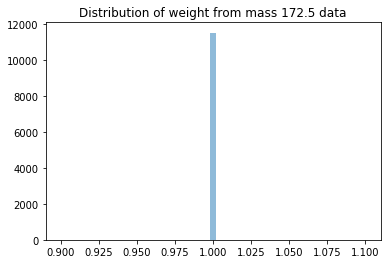

In [13]:
for i in range(5):
    reweighting()